In [1]:
! pip -q install lightgbm statsmodels

Feature table loaded: rows=43 | range=2014-06-30 → 2024-12-31
Samples available for RQ-1 after NA drop: n=43
CV folds: 17  [LightGBM as enriched]
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 0.004152
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

,R2,MAE,MAPE,HitRate,MAE_improve_%,ΔR2,ΔMAE,ΔMAPE,ΔHitRate
Baseline(ret_prev_q),-0.1935,0.0413,1.0341,0.7059,NaN,0.0000,0.0000,0.0000,0.0000
Enriched(Model),-0.1571,0.0416,1.0739,0.7059,-0.6727,0.0364,0.0003,0.0398,0.0000



RQ-1 verdict: NOT MET ❌
ΔR² = 0.036 | MAE improve = -0.7% | ΔHitRate = 0.000
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] Start training from score -0.000763
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM]

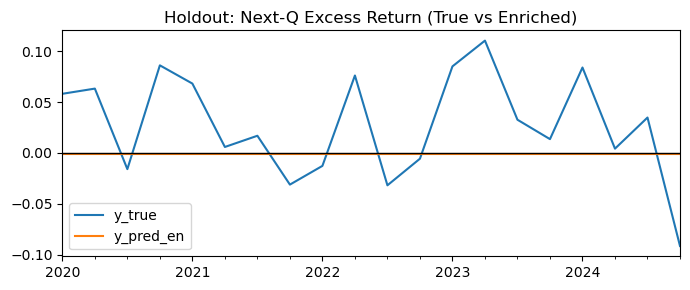


Saved:
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_metrics_baseline_vs_enriched.csv
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_metrics_deltas_only.csv
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_conclusion.txt
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_holdout_metrics.csv
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_holdout_predictions.csv
  - C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_slides_table.csv


In [2]:
# ================================
# RQ-1 MODEL BUILDER (Baseline vs Enriched)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Try LightGBM; fallback to GradientBoostingRegressor if unavailable
try:
    from lightgbm import LGBMRegressor
    _USE_LGBM = True
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor as LGBMRegressor
    _USE_LGBM = False

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# ----------------
# Load features
# ----------------
PROC = Path('./processed'); PROC.mkdir(exist_ok=True)

path_parq = PROC/'quarterly_features.parquet'
path_csv  = PROC/'quarterly_features.csv'
if path_parq.exists():
    qdf = pd.read_parquet(path_parq)
elif path_csv.exists():
    qdf = pd.read_csv(path_csv, index_col=0, parse_dates=True)
else:
    raise FileNotFoundError("Processed features not found. Expected ./processed/quarterly_features.(parquet|csv)")

# ensure datetime index
qdf.index = pd.to_datetime(qdf.index)

# Columns we need for RQ-1
needed = ['midcap_qret','nifty_qret','excess_ret','rain_anom','cpi_yoy','gdp_yoy','repo_chg_bps',
          'ret_prev_q','rain_anom_lag','cpi_yoy_lag','gdp_yoy_lag','repo_chg_lag','excess_next_q']
missing = [c for c in needed if c not in qdf.columns]
if missing:
    raise ValueError(f"Missing columns from Feature Builder: {missing}")

print(f"Feature table loaded: rows={len(qdf)} | range={qdf.index.min().date()} → {qdf.index.max().date()}")

# ----------------
# Train/Test tag (for holdout reporting)
# ----------------
cutoff = '2019-12-31'
qdf['set'] = np.where(qdf.index <= cutoff, 'train', 'test')

# ----------------
# Helper functions
# ----------------
def hit_rate(y_true, y_pred):
    return float(np.mean(np.sign(y_true) == np.sign(y_pred)))

def make_expanding_splits(n, min_train=None, test_size=2, step=1):
    """Expanding window splits: [0:min_train) train, next test_size as test, advance by step."""
    if min_train is None:
        min_train = max(12, int(round(n * 0.6)))
    splits = []
    start = min_train
    while start + test_size <= n:
        tr = np.arange(0, start)
        te = np.arange(start, start + test_size)
        splits.append((tr, te))
        start += step
    return splits

def cv_eval(model_maker, X, y, splits):
    y_true_all, y_pred_all = [], []
    for tr, te in splits:
        mdl = model_maker()
        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])
        y_true_all.extend(y.iloc[te].values)
        y_pred_all.extend(pred)
    if len(y_true_all) == 0:
        raise ValueError("No CV folds produced any test samples. Reduce min_train or test_size.")
    y_true_all, y_pred_all = np.array(y_true_all), np.array(y_pred_all)
    return dict(
        R2=r2_score(y_true_all, y_pred_all),
        MAE=mean_absolute_error(y_true_all, y_pred_all),
        MAPE=mean_absolute_percentage_error(y_true_all, y_pred_all),
        HitRate=hit_rate(y_true_all, y_pred_all)
    ), pd.DataFrame({'y_true': y_true_all, 'y_pred': y_pred_all})

# ----------------
# Feature sets
# ----------------
target = 'excess_next_q'
base_feats = ['ret_prev_q']
enriched_feats = ['ret_prev_q','rain_anom_lag','gdp_yoy_lag','cpi_yoy_lag','repo_chg_lag']

X_base = qdf[base_feats].apply(pd.to_numeric, errors='coerce')
X_en   = qdf[enriched_feats].apply(pd.to_numeric, errors='coerce')
y      = pd.to_numeric(qdf[target], errors='coerce')

# drop any residual NaNs across used columns
mask = (~X_en.isna().any(axis=1)) & (~y.isna())
X_base, X_en, y = X_base[mask], X_en[mask], y[mask]
print(f"Samples available for RQ-1 after NA drop: n={len(y)}")

# ----------------
# CV splitter (fallback to holdout if needed)
# ----------------
n = len(y)
splits = make_expanding_splits(n, min_train=max(12, int(0.6*n)), test_size=2, step=1)
if len(splits) == 0:
    print("⚠ Not enough samples for expanding CV. Falling back to holdout: last 8 points (or 25% if smaller).")
    test_size = min(8, max(2, n // 4))
    tr_idx = np.arange(0, n - test_size)
    te_idx = np.arange(n - test_size, n)
    splits = [(tr_idx, te_idx)]
print(f"CV folds: {len(splits)}  [{'LightGBM' if _USE_LGBM else 'Sklearn GBDT'} as enriched]")

# ----------------
# Models
# ----------------
def make_baseline():
    return Pipeline([
        ('sc', StandardScaler(with_mean=True, with_std=True)),
        ('enet', ElasticNetCV(cv=3, l1_ratio=[0.1,0.5,0.9], random_state=42))
    ])

def make_lgbm():
    # If LightGBM is installed, this is LGBM; otherwise it's sklearn's GBDT fallback
    return LGBMRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3,
        subsample=0.9, colsample_bytree=0.9 if _USE_LGBM else 1.0, random_state=42
    )

# ----------------
# Evaluate (walk-forward CV or holdout-fallback)
# ----------------
m_base, preds_base = cv_eval(make_baseline, X_base, y, splits)
m_en,   preds_en   = cv_eval(make_lgbm,   X_en,   y, splits)

results_rq1 = pd.DataFrame([m_base, m_en], index=['Baseline(ret_prev_q)', 'Enriched(Model)'])

# Δ vs baseline
delta = results_rq1.subtract(results_rq1.loc['Baseline(ret_prev_q)'], axis='columns')
delta = delta.rename(columns=lambda c: f'Δ{c}')

# % MAE improvement (positive = better)
baseline_mae = results_rq1.loc['Baseline(ret_prev_q)', 'MAE']
results_rq1['MAE_improve_%'] = np.nan
results_rq1.loc['Enriched(Model)', 'MAE_improve_%'] = (baseline_mae - results_rq1.loc['Enriched(Model)', 'MAE']) / baseline_mae * 100.0

# Final table
results_rq1 = pd.concat([results_rq1, delta], axis=1)
display(results_rq1)

# ----------------
# PASS/FAIL vs your criteria
# ----------------
MIN_DELTA_R2       = 0.10   # ≥ +0.10
MIN_MAE_IMPROVE_PCT= 10.0   # ≥ +10%

d = results_rq1.filter(like='Δ').loc['Enriched(Model)']
mae_improve_pct = results_rq1.loc['Enriched(Model)', 'MAE_improve_%']
rq1_pass = (d['ΔR2'] >= MIN_DELTA_R2) and (mae_improve_pct >= MIN_MAE_IMPROVE_PCT)

print("\nRQ-1 verdict:", "PASS ✅" if rq1_pass else "NOT MET ❌")
print(f"ΔR² = {d['ΔR2']:.3f} | MAE improve = {mae_improve_pct:.1f}% | ΔHitRate = {d['ΔHitRate']:.3f}")

# ----------------
# Save slide-ready artifacts
# ----------------
results_rq1.to_csv(PROC/'rq1_metrics_baseline_vs_enriched.csv')

delta_only = delta.loc[['Enriched(Model)']].copy()
delta_only.to_csv(PROC/'rq1_metrics_deltas_only.csv')

with open(PROC/'rq1_conclusion.txt', 'w') as f:
    f.write(
        f"RQ-1: {'PASS' if rq1_pass else 'NOT MET'} | "
        f"ΔR²={d['ΔR2']:.3f}, MAE improve={mae_improve_pct:.1f}%, ΔHitRate={d['ΔHitRate']:.3f}\n"
        f"Baseline = ElasticNet(ret_prev_q). Enriched = {'LightGBM' if _USE_LGBM else 'GBDT'}(ret_prev_q + rain/gdp/cpi/repo lags)."
    )

# ----------------
# Optional: fixed train/test holdout diagnostics for slides
# ----------------
train_mask = qdf.loc[mask, 'set'] == 'train'
test_mask  = qdf.loc[mask, 'set'] == 'test'

base_fit = make_baseline().fit(X_base[train_mask], y[train_mask])
en_fit   = make_lgbm().fit(X_en[train_mask], y[train_mask])

pred_base_test = base_fit.predict(X_base[test_mask])
pred_en_test   = en_fit.predict(X_en[test_mask])

def metric_row(y_true, y_pred):
    return dict(
        R2=r2_score(y_true, y_pred),
        MAE=mean_absolute_error(y_true, y_pred),
        MAPE=mean_absolute_percentage_error(y_true, y_pred),
        HitRate=hit_rate(y_true, y_pred)
    )

holdout_metrics = pd.DataFrame([
    metric_row(y[test_mask], pred_base_test),
    metric_row(y[test_mask], pred_en_test)
], index=['Holdout-Baseline', 'Holdout-Enriched'])

holdout_metrics.to_csv(PROC/'rq1_holdout_metrics.csv')

test_tbl = pd.DataFrame({
    'y_true': y[test_mask].values,
    'y_pred_base': pred_base_test,
    'y_pred_en': pred_en_test
}, index=y[test_mask].index)
test_tbl.to_csv(PROC/'rq1_holdout_predictions.csv')

# Optional tiny plot for slide
ax = test_tbl[['y_true','y_pred_en']].plot(figsize=(7,3), title='Holdout: Next-Q Excess Return (True vs Enriched)')
ax.axhline(0, lw=1, color='k'); ax.figure.tight_layout()
plt.show()

# Also save a compact slide table
slides_tbl = results_rq1[['R2','MAE','HitRate','MAE_improve_%']].round(3)
slides_tbl.to_csv(PROC/'rq1_slides_table.csv', index=True)

print("\nSaved:")
for fn in ['rq1_metrics_baseline_vs_enriched.csv','rq1_metrics_deltas_only.csv',
           'rq1_conclusion.txt','rq1_holdout_metrics.csv','rq1_holdout_predictions.csv',
           'rq1_slides_table.csv']:
    print("  -", (PROC/fn).resolve())


# Save for slides
results_rq1.to_csv(PROC/'rq1_metrics_baseline_vs_enriched.csv')

,Group,N,Mean next-Q excess,Std
0,Good rain (>= +4%),20,0.0108,0.0421
1,Poor rain (<= -4%),18,0.0333,0.0481


t-test p=0.1357 | KS p=0.3095 | Cohen's d=-0.50


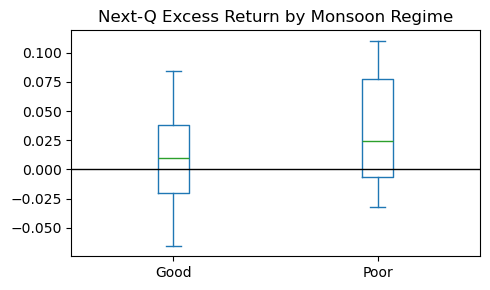

In [3]:
# ================================
# RQ-2: GOOD vs POOR MONSOON IMPACT
# ================================
import numpy as np, pandas as pd
from scipy.stats import ttest_ind, ks_2samp

target = 'excess_next_q'

# You can tweak thresholds here if needed
GOOD_THRESHOLD = +4.0   # anomaly % >= +4% = "good monsoon"
POOR_THRESHOLD = -4.0   # anomaly % <= -4% = "poor monsoon"

good = qdf.loc[qdf['rain_anom_lag'] >= GOOD_THRESHOLD, target].dropna()
poor = qdf.loc[qdf['rain_anom_lag'] <= POOR_THRESHOLD, target].dropna()

def cohens_d(a, b):
    a, b = pd.Series(a).dropna(), pd.Series(b).dropna()
    na, nb = len(a), len(b)
    s_p = np.sqrt(((na-1)*a.var(ddof=1) + (nb-1)*b.var(ddof=1)) / (na+nb-2))
    return float((a.mean() - b.mean()) / s_p)

# Summary table
rq2_groups = pd.DataFrame({
    'Group': ['Good rain (>= +4%)', 'Poor rain (<= -4%)'],
    'N': [len(good), len(poor)],
    'Mean next-Q excess': [good.mean(), poor.mean()],
    'Std': [good.std(ddof=1), poor.std(ddof=1)]
})

# Tests
tres = ttest_ind(good, poor, equal_var=False)    # Welch t-test
ksres = ks_2samp(good, poor)
d = cohens_d(good, poor)

display(rq2_groups)
print(f"t-test p={tres.pvalue:.4f} | KS p={ksres.pvalue:.4f} | Cohen's d={d:.2f}")

# Save slide-ready artifacts
rq2_groups.to_csv(PROC/'rq2_monsoon_groups.csv', index=False)
with open(PROC/'rq2_tests.txt','w') as f:
    f.write(f"t_test_p={tres.pvalue:.6f}\nks_p={ksres.pvalue:.6f}\ncohen_d={d:.4f}\n")

# Optional: a tiny boxplot for slides
ax = pd.DataFrame({'Good': good, 'Poor': poor}).plot(kind='box', figsize=(5,3), title='Next-Q Excess Return by Monsoon Regime')
ax.axhline(0, lw=1, color='k'); ax.figure.tight_layout()

In [4]:
# ================================
# RQ-3: RAIN → GDP_(t+1) + UPLIFT IN MODEL
# ================================
# --- Compute CV metrics for "no gdp_pred" vs "+ gdp_pred"
m_en_no   = cv_eval(make_lgbm, X_en,   y_plus, splits_plus)    # returns a dict
m_en_plus = cv_eval(make_lgbm, X_plus, y_plus, splits_plus)    # returns a dict

# main table
rq3_tbl = pd.DataFrame([m_en_no, m_en_plus],
                       index=['Enriched(no gdp_pred)', 'Enriched(+ gdp_pred)'])

# Δ vs the 'no gdp_pred' row, per column
rq3_delta = rq3_tbl.subtract(rq3_tbl.loc['Enriched(no gdp_pred)'], axis='columns')
rq3_delta = rq3_delta.rename(columns=lambda c: f'Δ{c}')

# final table (metrics + deltas)
rq3_tbl = pd.concat([rq3_tbl, rq3_delta], axis=1)
display(rq3_tbl)

# save for slides
rq3_tbl.to_csv(PROC/'rq3_enriched_with_gdp_pred.csv')

NameError: name 'y_plus' is not defined

In [ ]:
# ================================
# RQ-4: DRIVER ATTRIBUTION
# ================================
qdf['rain_repo_int'] = qdf['rain_anom_lag'] * qdf['repo_chg_lag']
feat_int = ['ret_prev_q','rain_anom_lag','gdp_yoy_lag','cpi_yoy_lag','repo_chg_lag','rain_repo_int']

X_int = qdf[feat_int].apply(pd.to_numeric, errors='coerce')
y_int = pd.to_numeric(qdf['excess_next_q'], errors='coerce')
mask_int = (~X_int.isna().any(axis=1)) & (~y_int.isna())
X_int, y_int = X_int[mask_int], y_int[mask_int]

# Build splits with a small fallback if needed
def make_expanding_splits(n, min_train=None, test_size=2, step=1):
    if min_train is None:
        min_train = max(12, int(round(n*0.6)))
    splits = []
    start = min_train
    while start + test_size <= n:
        tr = np.arange(0, start)
        te = np.arange(start, start + test_size)
        splits.append((tr, te))
        start += step
    return splits

splits_int = make_expanding_splits(len(y_int), min_train=max(12, int(0.6*len(y_int))), test_size=2, step=1)
if len(splits_int) == 0:
    # holdout fallback: last 8 (or 25% if smaller)
    tsize = min(8, max(2, len(y_int)//4))
    tr = np.arange(0, len(y_int)-tsize)
    te = np.arange(len(y_int)-tsize, len(y_int))
    splits_int = [(tr, te)]

# Recreate the enriched (no interaction) set on the same mask for apples-to-apples comparison
enriched_feats = ['ret_prev_q','rain_anom_lag','gdp_yoy_lag','cpi_yoy_lag','repo_chg_lag']
X_en_masked = qdf[enriched_feats].apply(pd.to_numeric, errors='coerce').loc[X_int.index]

# CV evaluator (must return a dict)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
def cv_eval(model_maker, X, y, splits):
    y_true_all, y_pred_all = [], []
    for tr, te in splits:
        mdl = model_maker()
        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])
        y_true_all.extend(y.iloc[te].values)
        y_pred_all.extend(pred)
    y_true_all, y_pred_all = np.array(y_true_all), np.array(y_pred_all)
    return dict(R2=r2_score(y_true_all, y_pred_all),
                MAE=mean_absolute_error(y_true_all, y_pred_all),
                MAPE=mean_absolute_percentage_error(y_true_all, y_pred_all))

# Model factory (LightGBM or sklearn fallback)
def make_lgbm():
    try:
        from lightgbm import LGBMRegressor
        return LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=3,
                             subsample=0.9, colsample_bytree=0.9, random_state=42)
    except Exception:
        from sklearn.ensemble import GradientBoostingRegressor
        return GradientBoostingRegressor(random_state=42)

# Evaluate
m_full = cv_eval(make_lgbm, X_en_masked, y_int, splits_int)   # enriched (no interaction)
m_int  = cv_eval(make_lgbm, X_int,        y_int, splits_int)  # enriched + interaction

rq4_int_tbl = pd.DataFrame([m_full, m_int], index=['Enriched', 'Enriched+interaction'])

# ✅ compute delta columns properly and concat
rq4_int_delta = rq4_int_tbl.subtract(rq4_int_tbl.loc['Enriched'], axis='columns')
rq4_int_delta = rq4_int_delta.rename(columns=lambda c: f'Δ{c}')
rq4_int_tbl   = pd.concat([rq4_int_tbl, rq4_int_delta], axis=1)

display(rq4_int_tbl)

# Save for slides
rq4_int_tbl.to_csv(PROC/'rq4_interaction_uplift.csv')
rq4_int_delta.loc[['Enriched+interaction']].to_csv(PROC/'rq4_interaction_deltas_only.csv')